In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix , classification_report
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split , StratifiedKFold , RandomizedSearchCV
from tensorflow.keras.layers import Dense , InputLayer , Dropout , Conv2D , MaxPooling2D , Flatten , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import  relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model , save_model
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/My Drive/emnist-digits-train.csv')
test = pd.read_csv('/content/drive/My Drive/emnist-digits-test.csv')

Mounted at /content/drive


In [3]:
x_train = np.array(train.iloc[:, 1:].values)
y_train = np.array(train.iloc[:, 0].values)
x_test = np.array(test.iloc[:, 1:].values)
y_test = np.array(test.iloc[:, 0].values)


In [4]:
x_train = x_train/255.0
x_test = x_test/255.0

In [5]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

Class Distribution in Training Set:
Class 0: 24000 instances
Class 1: 24000 instances
Class 2: 24000 instances
Class 3: 24000 instances
Class 4: 24000 instances
Class 5: 24000 instances
Class 6: 24000 instances
Class 7: 24000 instances
Class 8: 23999 instances
Class 9: 24000 instances


<ipython-input-6-7d10874b7f8f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette="Reds_d")


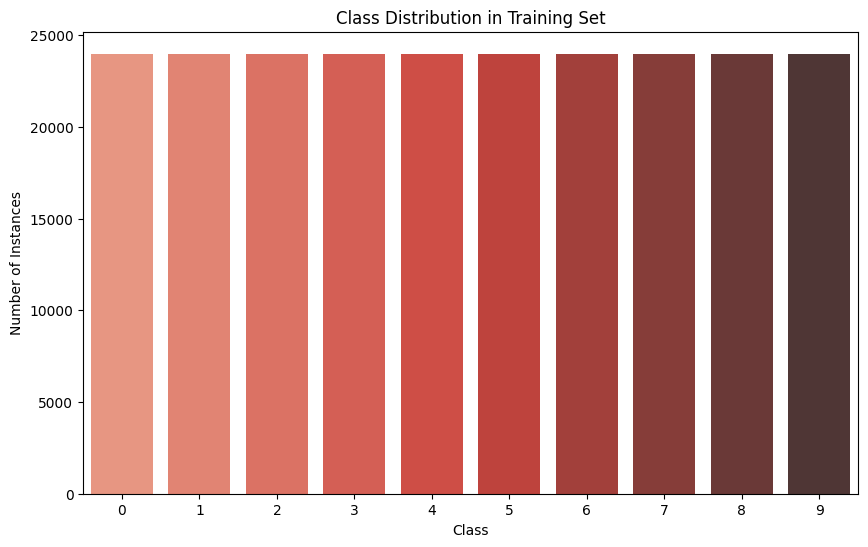

In [6]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class Distribution in Training Set:")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} instances")

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette="Reds_d")
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Training Set')
plt.show()

In [13]:
nums = [ '0','1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9']

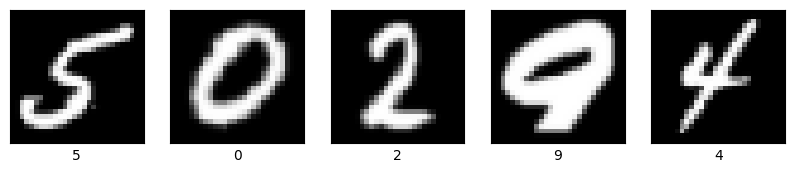

In [14]:
ra = np.random.choice(len(x_train), size=5, replace=False)

plt.figure(figsize=(10, 2))
for i in range(len(ra)):
    plt.subplot(1, len(ra), i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[ra[i]].reshape(28, 28).T, cmap='gray')  # Reshape to 28x28
    # Subtract 1 from y_train to map 1-based labels to 0-based indices
    plt.xlabel(nums[y_train[ra[i]] ], fontsize=10, color='black', ha='center')
    plt.subplots_adjust(hspace=0.5)
plt.show()

In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 439,370 (1.68 MB)

 Trainable params: 439,370 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="best.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [26]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=32, callbacks=[model_checkpoint_callback])


Epoch 1/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9223 - loss: 0.2409
Epoch 1: val_accuracy improved from -inf to 0.97980, saving model to best.keras
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 333s 44ms/step - accuracy: 0.9223 - loss: 0.2408 - val_accuracy: 0.9798 - val_loss: 0.0788
Epoch 2/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9865 - loss: 0.0567
Epoch 2: val_accuracy improved from 0.97980 to 0.98935, saving model to best.keras
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 367s 42ms/step - accuracy: 0.9865 - loss: 0.0567 - val_accuracy: 0.9893 - val_loss: 0.0456
Epoch 3/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9891 - loss: 0.0453
Epoch 3: val_accuracy did not improve from 0.98935
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 326s 42ms/step - accuracy: 0.9891 - loss: 0.0453 - val_accuracy: 0.9884 - val_loss: 0.0497
Epoch 4/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9902 - loss: 0.0413
Epoch 4: val_accuracy improved from 0.98935 to 0.98992, saving m

In [36]:
model.save('/content/drive/My Drive/eng-digits_opt.h5')

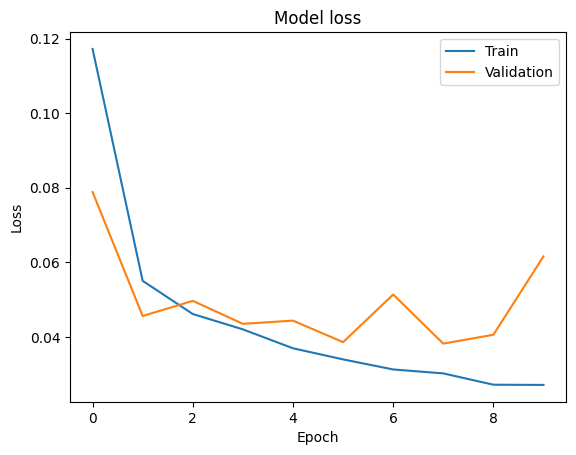

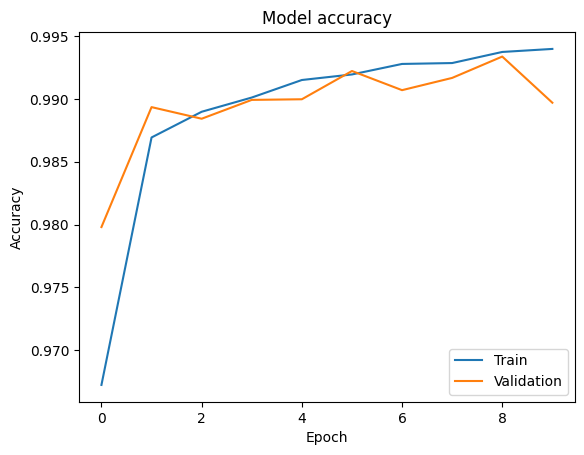

In [27]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [28]:
x_test_reshaped = x_test.reshape(-1, 28, 28, 1)

pred = model.predict(x_test_reshaped)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step


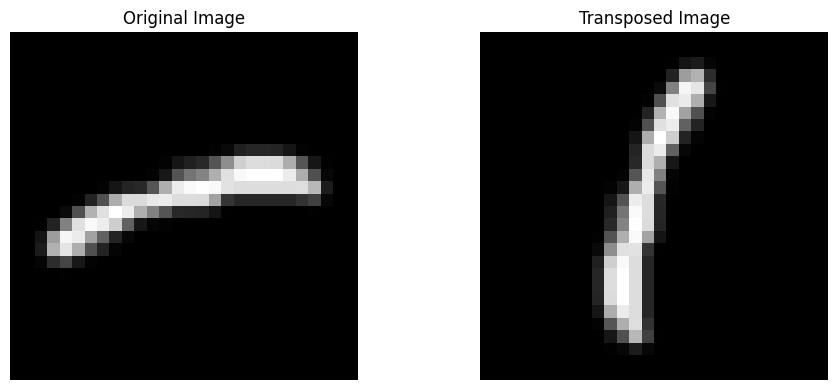

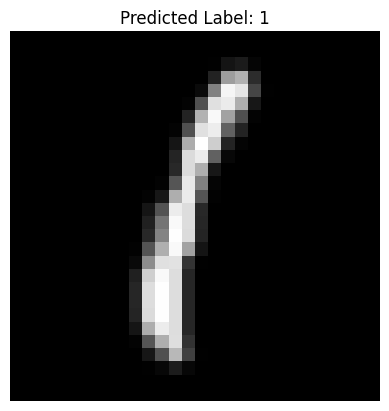

In [33]:
predicted_label = nums[np.argmax(pred[6])]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(x_test[6].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(x_test[6].reshape(28, 28).T, cmap='gray')
plt.axis('off')
plt.title('Transposed Image')

plt.tight_layout()
plt.show()

plt.imshow(x_test[6].reshape(28, 28).T, cmap='gray')
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step


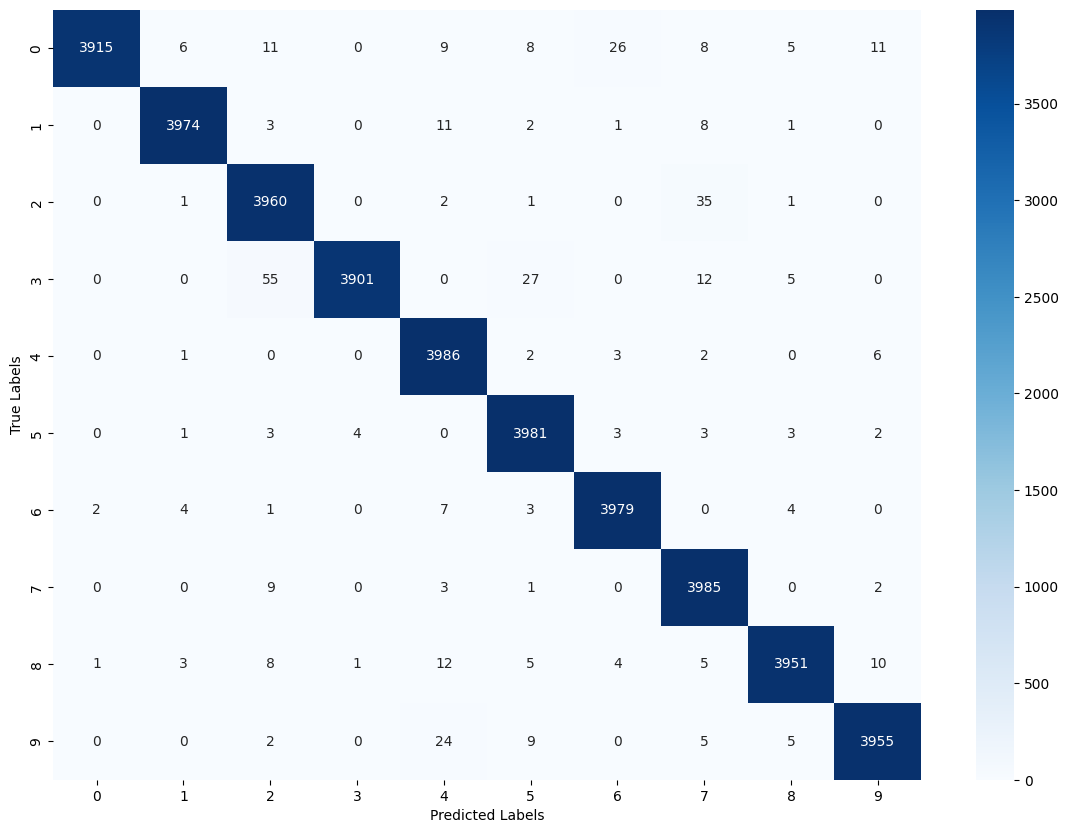

In [37]:
y_preds = model.predict(x_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_preds, axis=1)

# Since y_test is already in label form, no need to apply np.argmax
y_true = y_test

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heat map
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()